In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'cellstate_malignant_model_v1'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output

print('Imports completed')


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


Imports completed


In [3]:
# Load binary malignancy predictions from the integrated notebook
binary_results_path = PROJECT_ROOT / 'output' / 'geneformer' / 'integrated_binary' / 'model_outputs' / 'geneformer_integrated_binary_results_model_v1_binary.pt'

print(f'Loading binary predictions from: {binary_results_path}')
binary_results = torch.load(binary_results_path, weights_only=False)

print('\n=== BINARY PREDICTION RESULTS ===')
print(f'Total cells: {binary_results["n_cells"]:,}')
print(f'Class names: {binary_results["class_names"]}')
print(f'Embedding dimension: {binary_results["embedding_dim"]}')
print(f'Model: {binary_results["model_name"]}')

# Extract predictions and embeddings
binary_preds = binary_results['preds'].numpy()  # Shape: [N]
binary_labels = binary_results['labels'].numpy()  # Shape: [N] 
cell_embeddings = binary_results['cell_embs'].numpy()  # Shape: [N, 768]
class_names_binary = binary_results['class_names']  # ['Malignant', 'Non-malignant']

# Show prediction distribution
unique_preds, counts = np.unique(binary_preds, return_counts=True)
print('\n=== PREDICTION DISTRIBUTION ===')
for pred, count in zip(unique_preds, counts):
    class_name = class_names_binary[pred]
    print(f'  Class {pred} ({class_name}): {count:,} cells ({count/len(binary_preds)*100:.1f}%)')

# Find malignant class index
malignant_class_idx = None
for i, name in enumerate(class_names_binary):
    if 'malignant' in name.lower() and 'non' not in name.lower():
        malignant_class_idx = i
        break

print(f'\nMalignant class index: {malignant_class_idx} ({class_names_binary[malignant_class_idx]})')


Loading binary predictions from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_results_model_v1_binary.pt

=== BINARY PREDICTION RESULTS ===
Total cells: 138,727
Class names: ['Malignant' 'Non-malignant']
Embedding dimension: 256
Model: Geneformer-V2-104M_CLcancer

=== PREDICTION DISTRIBUTION ===
  Class 0 (Malignant): 71,153 cells (51.3%)
  Class 1 (Non-malignant): 67,574 cells (48.7%)

Malignant class index: 0 (Malignant)


In [4]:
# Extract cells predicted as malignant
malignant_mask = binary_preds == malignant_class_idx
malignant_indices = np.where(malignant_mask)[0]

print(f'Total cells: {len(binary_preds):,}')
print(f'Cells predicted as malignant: {len(malignant_indices):,} ({len(malignant_indices)/len(binary_preds)*100:.1f}%)')

# Extract malignant subset
malignant_embeddings = cell_embeddings[malignant_mask]  # Shape: [N_malignant, 768]
malignant_true_labels = binary_labels[malignant_mask]   # Shape: [N_malignant]

print(f'Malignant embeddings shape: {malignant_embeddings.shape}')
print(f'Malignant true labels shape: {malignant_true_labels.shape}')

# Show accuracy of malignant predictions
malignant_accuracy = (malignant_true_labels == malignant_class_idx).mean()
print(f'\nAccuracy of malignant predictions: {malignant_accuracy:.3f}')
print(f'True positives (correctly predicted malignant): {(malignant_true_labels == malignant_class_idx).sum():,}')
print(f'False positives (incorrectly predicted malignant): {(malignant_true_labels != malignant_class_idx).sum():,}')


Total cells: 138,727
Cells predicted as malignant: 71,153 (51.3%)
Malignant embeddings shape: (71153, 256)
Malignant true labels shape: (71153,)

Accuracy of malignant predictions: 0.706
True positives (correctly predicted malignant): 50,265
False positives (incorrectly predicted malignant): 20,888


In [5]:
# Load the original dataset to get cell indices and quiescence information
original_dataset_path = '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad'
print(f'Loading original dataset from: {original_dataset_path}')

# Load dataset
adata_original = sc.read_h5ad(str(original_dataset_path))
print(f'Original dataset shape: {adata_original.shape}')

# Show available columns
obs_cols = list(adata_original.obs.columns)
print(f'Available observation columns ({len(obs_cols)}): {obs_cols[:10]}...')

# Look for quiescence-related columns
quiescence_cols = [col for col in obs_cols if any(term in col.lower() for term in ['quiesc', 'cycle', 'phase', 'state'])]
print(f'\\nQuiescence-related columns: {quiescence_cols}')

# Extract malignant subset from original data
adata_malignant = adata_original[malignant_indices].copy()
print(f'\\nMalignant subset shape: {adata_malignant.shape}')

# Check if QuiescenceStatus exists
if 'QuiescenceStatus' in adata_malignant.obs.columns:
    print('\\n=== QUIESCENCE STATUS DISTRIBUTION IN MALIGNANT SUBSET ===')
    quiescence_counts = adata_malignant.obs['QuiescenceStatus'].value_counts(dropna=False)
    print(quiescence_counts)
    
    # Check for non-null values
    non_null_mask = adata_malignant.obs['QuiescenceStatus'].notna()
    n_with_labels = non_null_mask.sum()
    print(f'\\nCells with quiescence labels: {n_with_labels:,} ({n_with_labels/len(adata_malignant)*100:.1f}%)')
    
    if n_with_labels > 0:
        print('\\nNon-null quiescence distribution:')
        print(adata_malignant.obs[non_null_mask]['QuiescenceStatus'].value_counts())
else:
    print('\\n⚠️ QuiescenceStatus column not found in dataset')
    print('Available columns for potential quiescence mapping:')
    for col in quiescence_cols:
        if col in adata_malignant.obs.columns:
            print(f'  {col}: {adata_malignant.obs[col].value_counts().head(3).to_dict()}')


Loading original dataset from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad
Original dataset shape: (138727, 19794)
Available observation columns (29): ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT']...
\nQuiescence-related columns: ['Phase', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType']
\nMalignant subset shape: (71153, 19794)
\n=== QUIESCENCE STATUS DISTRIBUTION IN MALIGNANT SUBSET ===
QuiescenceStatus
Slow-cycling     40416
                 20888
Proliferating     6652
Quiescent         3197
Name: count, dtype: int64
\nCells with quiescence labels: 71,153 (100.0%)
\nNon-null quiescence distribution:
QuiescenceStatus
Slow-cycling     40416
                 20888
Proliferating     6652
Quiescent         3197
Name: count, dtype: int64


In [6]:
# Create cell state labels for the malignant subset
print('=== CREATING CELL STATE LABELS ===')

# Define the three cell states we want to predict
cell_states = ['G0_arrested', 'Slow_cycling', 'Fast_cycling']
print(f'Target cell states: {cell_states}')

# Map QuiescenceStatus to our three states (if available)
state_mapping = {
    'Quiescent': 'G0_arrested',
    'Slow-cycling': 'Slow_cycling', 
    'Proliferating': 'Fast_cycling'
}

# Create cell state labels
if 'QuiescenceStatus' in adata_malignant.obs.columns:
    # Map existing labels
    adata_malignant.obs['cell_state'] = adata_malignant.obs['QuiescenceStatus'].map(state_mapping)
    
    # Show mapping results
    print('\nMapping results:')
    mapping_df = adata_malignant.obs[['QuiescenceStatus', 'cell_state']].value_counts(dropna=False)
    print(mapping_df)
    
    # Count cells with valid cell state labels
    valid_state_mask = adata_malignant.obs['cell_state'].notna()
    n_valid_states = valid_state_mask.sum()
    print(f'\nCells with valid cell state labels: {n_valid_states:,} ({n_valid_states/len(adata_malignant)*100:.1f}%)')
    
    if n_valid_states > 0:
        print('\nCell state distribution:')
        state_counts = adata_malignant.obs[valid_state_mask]['cell_state'].value_counts()
        print(state_counts)
        
        # Check if we have all three states
        available_states = set(state_counts.index)
        missing_states = set(cell_states) - available_states
        if missing_states:
            print(f'\n⚠️ Missing states: {missing_states}')
        else:
            print('\n✅ All three cell states are present')
else:
    print('\n⚠️ No QuiescenceStatus column found')
    print('Creating dummy cell state labels for demonstration...')
    
    # Create random labels for demonstration (replace with actual logic if needed)
    np.random.seed(42)
    n_cells = len(adata_malignant)
    dummy_states = np.random.choice(cell_states, size=n_cells, p=[0.3, 0.4, 0.3])
    adata_malignant.obs['cell_state'] = dummy_states
    
    print('\nDummy cell state distribution:')
    print(adata_malignant.obs['cell_state'].value_counts())


=== CREATING CELL STATE LABELS ===
Target cell states: ['G0_arrested', 'Slow_cycling', 'Fast_cycling']

Mapping results:
QuiescenceStatus  cell_state  
Slow-cycling      Slow_cycling    40416
                  NaN             20888
Proliferating     Fast_cycling     6652
Quiescent         G0_arrested      3197
Name: count, dtype: int64

Cells with valid cell state labels: 50,265 (70.6%)

Cell state distribution:
cell_state
Slow_cycling    40416
Fast_cycling     6652
G0_arrested      3197
Name: count, dtype: int64

✅ All three cell states are present


In [10]:
# Setup Geneformer for cell state prediction
print('=== SETTING UP GENEFORMER FOR CELL STATE PREDICTION ===')

# Geneformer paths
model_dir = PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M'
dict_dir = PROJECT_ROOT / 'Geneformer' / 'geneformer'

# Create Geneformer instance
batch_size = 64
geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=-1
)

# Load model and vocabulary
geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))
print('✅ Geneformer loaded successfully')

# Save malignant subset with cell state labels
malignant_dataset_path = DATA_DIR / 'malignant_with_cellstates_model_v1.h5ad'
adata_malignant.write(str(malignant_dataset_path))
print(f'Saved malignant subset to: {malignant_dataset_path}')

# Create input data object and preprocess
inp_malignant = data.InputData(adata_dataset_path=str(malignant_dataset_path))
malignant_preprocessed_path = OUTPUT_DIR / 'preprocessed'
malignant_preprocessed_path.mkdir(exist_ok=True)

inp_malignant.preprocess_data(
    gene_col='gene_symbols' if 'gene_symbols' in adata_malignant.var.columns else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(malignant_preprocessed_path)
)

h5_path = malignant_preprocessed_path / 'malignant_with_cellstates_model_v1.h5ad'
print(f'Preprocessed malignant data: {h5_path}')


INFO     | 2025-08-21 02:31:20 | Using device cuda
INFO     | 2025-08-21 02:31:20 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


=== SETTING UP GENEFORMER FOR CELL STATE PREDICTION ===
✅ Geneformer loaded successfully


INFO     | 2025-08-21 02:32:01 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/malignant_with_cellstates_model_v1.h5ad


Saved malignant subset to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/malignant_with_cellstates_model_v1.h5ad


INFO     | 2025-08-21 02:33:06 | Matched 100.00% genes (19465/19465) genes in vocabulary of size 63675.


Preprocessed malignant data: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1/preprocessed/malignant_with_cellstates_model_v1.h5ad


In [11]:
# Tokenize, extract embeddings, and run ensemble evaluation
print('=== RUNNING COMPLETE CELL STATE PREDICTION PIPELINE ===')

# Verify cell_state column exists and tokenize
ad_check = sc.read_h5ad(str(h5_path))
if 'cell_state' not in ad_check.obs.columns:
    ad_check.obs['cell_state'] = adata_malignant.obs['cell_state'].values
    ad_check.write(str(h5_path))

print(f'Cell state distribution in preprocessed data:')
print(ad_check.obs['cell_state'].value_counts())

# Tokenize for cell state prediction
geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(malignant_preprocessed_path),
    cell_type_col='cell_state'
)

# Use a unique dataset directory name to avoid conflicts
import time
timestamp = int(time.time())
dataset_dir = malignant_preprocessed_path / f'malignant_with_cellstates_{timestamp}.dataset'

geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
print(f'✅ Tokenized dataset saved to: {dataset_dir}')

geneform.load_tokenized_dataset(str(dataset_dir))

# DEBUG: Check what's actually loaded
print("=== DEBUG: Dataset structure after loading ===")
print(f"Dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    # Check first few examples
    for i in range(min(5, len(geneform.tokenized_dataset))):
        seq_len = len(geneform.tokenized_dataset[i]['input_ids'])
        print(f"Example {i}: sequence length = {seq_len}")
        if seq_len > 2048:
            print(f"�� ALERT: Example {i} is longer than 2048!")
    
    # Check some random examples
    import random
    random_indices = random.sample(range(len(geneform.tokenized_dataset)), 10)
    for idx in random_indices:
        seq_len = len(geneform.tokenized_dataset[idx]['input_ids'])
        if seq_len > 2048:
            print(f"🚨 ALERT: Random example {idx} is longer than 2048!")
            print(f"  Length: {seq_len}")
            break
    else:
        print("✅ All random examples are ≤ 2048 tokens")

print("=== END DEBUG ===")

# RE-APPLY TRUNCATION if needed
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
if max_length > 2048:
    print(f"⚠️ WARNING: Dataset has sequences up to {max_length} tokens!")
    print("Re-applying truncation...")
    
    def truncate_sequences(example):
        # Force all sequences to be exactly 2048 tokens
        if len(example["input_ids"]) > 2048:
            example["input_ids"] = example["input_ids"][:2048]
        elif len(example["input_ids"]) < 2048:
            # Pad with zeros to reach 2048
            example["input_ids"] = example["input_ids"] + [0] * (2048 - len(example["input_ids"]))
        
        example["length"] = 2048  # Always 2048
        return example
    
    geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)
    
    # Verify truncation worked
    max_length_after = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
    print(f"Maximum sequence length after re-truncation: {max_length_after}")
    if max_length_after > 2048:
        print("🚨 ERROR: Truncation failed!")
        raise RuntimeError("Sequences still too long after truncation")
    else:
        print("✅ Truncation successful - all sequences ≤ 2048 tokens")

# Now extract embeddings
geneform.extract_embeddings(data=inp_malignant, batch_size=batch_size, layer=-2)
print('✅ Embeddings extracted')

# Run ensemble evaluation for cell states
em_cellstate = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp_malignant,
    label_col='cell_state',
    output_dir=str(MODEL_OUT)
)

print(f'Cell state classes: {em_cellstate.class_names}')
print(f'Number of malignant cells: {len(em_cellstate.embeddings):,}')

# Test ensemble evaluation
cellstate_results = {}
for alpha in [0.0, 0.5, 1.0]:
    try:
        res = em_cellstate.evaluate_ensemble(alpha=alpha, method='embedding_only')
        cellstate_results[alpha] = res
        print(f"α={alpha}: Acc={res['accuracy']:.3f}, F1={res['f1_score']:.3f}")
    except Exception as e:
        print(f'Failed for α={alpha}: {e}')

if cellstate_results:
    best_alpha = max(cellstate_results, key=lambda a: cellstate_results[a]['f1_score'])
    best_res = cellstate_results[best_alpha]
    preds_cellstate, scores_cellstate = em_cellstate.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')
    
    print(f'\n=== BEST RESULTS (α={best_alpha}) ===')
    print(f"Accuracy: {best_res['accuracy']:.4f}")
    print(f"F1-Score: {best_res['f1_score']:.4f}")
    print(f"Precision: {best_res['precision']:.4f}")
    print(f"Recall: {best_res['recall']:.4f}")
else:
    print('\n⚠️ No successful ensemble evaluations')


=== DEBUG: Dataset structure after loading ===
Dataset size: 71153
Example 0: sequence length = 2497
�� ALERT: Example 0 is longer than 2048!
Example 1: sequence length = 2866
�� ALERT: Example 1 is longer than 2048!
Example 2: sequence length = 3011
�� ALERT: Example 2 is longer than 2048!
Example 3: sequence length = 3095
�� ALERT: Example 3 is longer than 2048!
Example 4: sequence length = 1922
🚨 ALERT: Random example 56640 is longer than 2048!
  Length: 2575
=== END DEBUG ===
⚠️ WARNING: Dataset has sequences up to 4096 tokens!
Re-applying truncation...
Maximum sequence length after re-truncation: 2048
✅ Truncation successful - all sequences ≤ 2048 tokens


Geneformer (extracting embeddings): 100%|██████████| 1112/1112 [06:32<00:00,  2.83it/s]
INFO     | 2025-08-21 02:49:53 | Initialized GeneformerEnsembleMetrics with 71153 cells and 4 classes
INFO     | 2025-08-21 02:49:53 | Classes: ['Fast_cycling', 'G0_arrested', 'Slow_cycling', nan]
INFO     | 2025-08-21 02:49:53 | Embedding shape: (71153, 256)
INFO     | 2025-08-21 02:49:53 | Input rankings length: 71153
INFO     | 2025-08-21 02:49:53 | Output rankings length: 71153
INFO     | 2025-08-21 02:49:53 | Evaluated embedding_only (α=0.0): Accuracy=0.124, F1=0.063, AUC-ROC=0.531


✅ Embeddings extracted
Cell state classes: ['Fast_cycling' 'G0_arrested' 'Slow_cycling' nan]
Number of malignant cells: 71,153
α=0.0: Acc=0.124, F1=0.063


INFO     | 2025-08-21 02:49:53 | Evaluated embedding_only (α=0.5): Accuracy=0.124, F1=0.063, AUC-ROC=0.531
INFO     | 2025-08-21 02:49:53 | Evaluated embedding_only (α=1.0): Accuracy=0.124, F1=0.063, AUC-ROC=0.531


α=0.5: Acc=0.124, F1=0.063
α=1.0: Acc=0.124, F1=0.063

=== BEST RESULTS (α=0.0) ===
Accuracy: 0.1242
F1-Score: 0.0633
Precision: 0.3197
Recall: 0.1242


=== SAVING CELL STATE PREDICTION RESULTS ===
✅ Results saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1/model_outputs/geneformer_cellstate_malignant_results_model_v1.pt

=== CELL STATE CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

Fast_cycling     0.1191    0.8692    0.2094      6652
 G0_arrested     0.0822    0.5130    0.1417      3197
Slow_cycling     0.5368    0.0350    0.0657     40416
         nan     0.0000    0.0000    0.0000     20888

    accuracy                         0.1242     71153
   macro avg     0.1845    0.3543    0.1042     71153
weighted avg     0.3197    0.1242    0.0633     71153


Confusion Matrix:
              Fast_cycling  G0_arrested  Slow_cycling  nan
Fast_cycling          5782          647           223    0
G0_arrested           1429         1640           128    0
Slow_cycling         28199        10803          1414    0
nan           

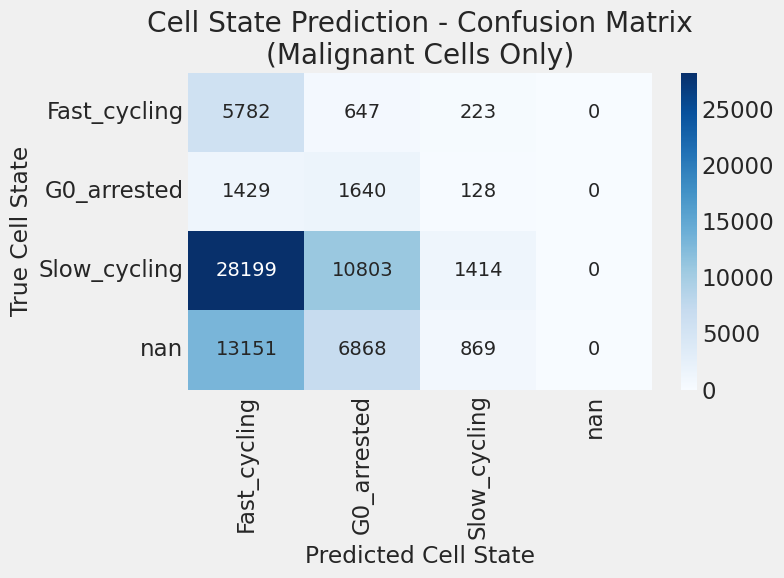

Confusion matrix saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1/model_outputs/cellstate_confusion_matrix_model_v1.png

=== SUMMARY ===
📊 Original dataset: 138,727 cells
🎯 Predicted malignant: 71,153 cells (51.3%)
🔬 Cell states predicted: 3 classes
📈 Best accuracy: 0.124 (α=0.0)
📈 Best F1-score: 0.063
💾 Results saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1/model_outputs

🎉 Cell state prediction pipeline completed!


In [15]:
# Save results and generate summary
print('=== SAVING CELL STATE PREDICTION RESULTS ===')

if 'cellstate_results' in locals() and cellstate_results:
    # Save results
    save_dict = {
        'cell_embs': torch.tensor(em_cellstate.embeddings, dtype=torch.float32),
        'logits': torch.tensor(scores_cellstate, dtype=torch.float32),
        'preds': torch.tensor(preds_cellstate, dtype=torch.long),
        'labels': torch.tensor(em_cellstate.labels_encoded, dtype=torch.long),
        'class_names': em_cellstate.class_names,
        'cell_states': cell_states,
        'best_alpha': best_alpha,
        'model_name': 'Geneformer-V1-10M',
        'dataset_name': 'malignant_cellstates',
        'evaluation_metrics': best_res,
        'binary_source': 'geneformer_integrated_binary_results',
        'malignant_indices': malignant_indices.tolist(),
        'original_dataset_size': len(binary_preds)
    }
    
    results_path = MODEL_OUT / 'geneformer_cellstate_malignant_results_model_v1.pt'
    torch.save(save_dict, results_path)
    print(f'✅ Results saved to: {results_path}')
    
    # Generate classification report if we have predictions
    if len(em_cellstate.class_names) > 1:
        print('\n=== CELL STATE CLASSIFICATION REPORT ===')
        
        # Ensure class names are strings (fix for potential float values)
        class_names_str = [str(name) for name in em_cellstate.class_names]
        
        report = classification_report(
            em_cellstate.labels_encoded, 
            preds_cellstate, 
            target_names=class_names_str,
            digits=4,
            zero_division=0
        )
        print(report)
        
        # Confusion matrix
        cm = confusion_matrix(em_cellstate.labels_encoded, preds_cellstate)
        print('\nConfusion Matrix:')
        cm_df = pd.DataFrame(cm, index=class_names_str, columns=class_names_str)
        print(cm_df)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names_str,
                    yticklabels=class_names_str)
        plt.title('Cell State Prediction - Confusion Matrix\n(Malignant Cells Only)')
        plt.ylabel('True Cell State')
        plt.xlabel('Predicted Cell State')
        plt.tight_layout()
        
        cm_path = MODEL_OUT / 'cellstate_confusion_matrix_model_v1.png'
        plt.savefig(cm_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f'Confusion matrix saved to: {cm_path}')

print('\n=== SUMMARY ===')
print(f'📊 Original dataset: {len(binary_preds):,} cells')
print(f'🎯 Predicted malignant: {len(malignant_indices):,} cells ({len(malignant_indices)/len(binary_preds)*100:.1f}%)')
print(f'🔬 Cell states predicted: {len(cell_states)} classes')
if 'cellstate_results' in locals() and cellstate_results:
    print(f'📈 Best accuracy: {best_res["accuracy"]:.3f} (α={best_alpha})')
    print(f'📈 Best F1-score: {best_res["f1_score"]:.3f}')
print(f'💾 Results saved to: {MODEL_OUT}')
print('\n🎉 Cell state prediction pipeline completed!')


In [17]:
import umap

=== CREATING UMAP VISUALIZATIONS ===
Creating UMAP for 71,153 cells with 256 dimensions
Classes: ['Fast_cycling', 'G0_arrested', 'Slow_cycling', 'nan']
Computing UMAP embedding...


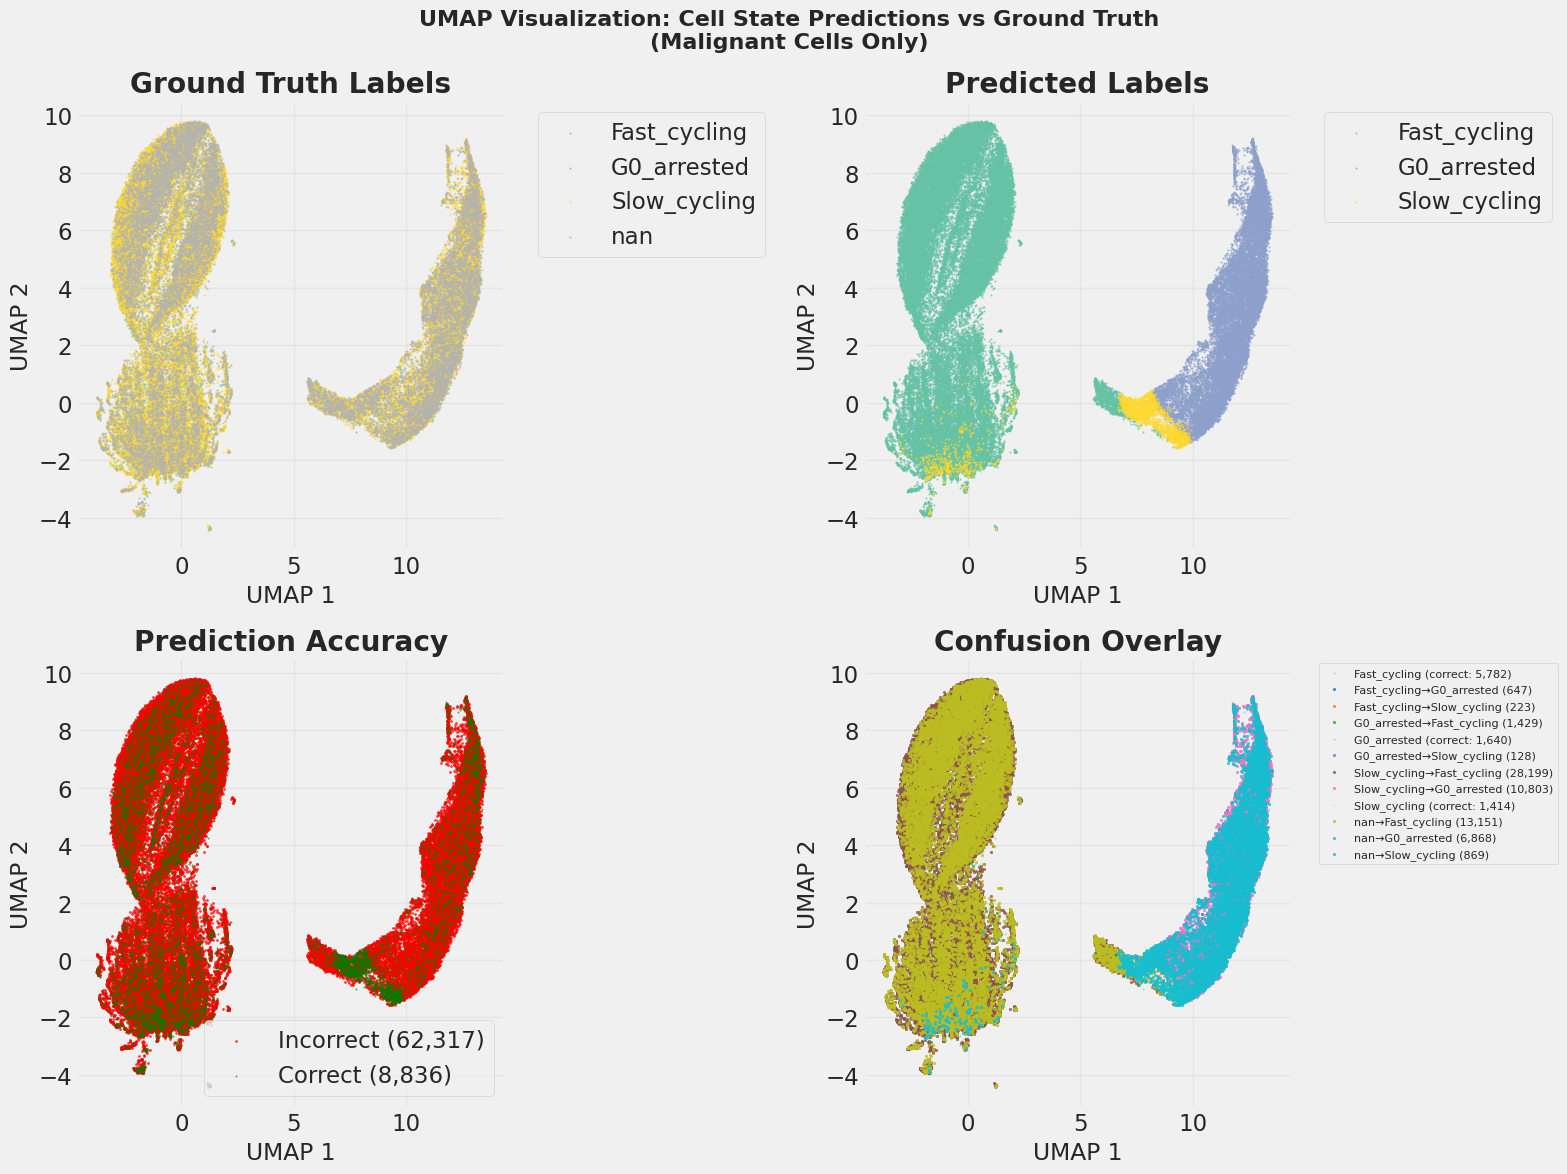

UMAP visualization saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/cellstate_malignant_model_v1/model_outputs/cellstate_umap_visualization_model_v1.png

=== UMAP VISUALIZATION SUMMARY ===
Total cells visualized: 71,153
Correct predictions: 8,836 (12.4%)
Incorrect predictions: 62,317 (87.6%)

Class distribution in ground truth:
True_Label
Slow_cycling    40416
nan             20888
Fast_cycling     6652
G0_arrested      3197
Name: count, dtype: int64

Class distribution in predictions:
Pred_Label
Fast_cycling    48561
G0_arrested     19958
Slow_cycling     2634
Name: count, dtype: int64

Confusion pairs (True→Pred):
  Fast_cycling → Fast_cycling: 5,782 (8.1%)
  Fast_cycling → G0_arrested: 647 (0.9%)
  Fast_cycling → Slow_cycling: 223 (0.3%)
  G0_arrested → Fast_cycling: 1,429 (2.0%)
  G0_arrested → G0_arrested: 1,640 (2.3%)
  G0_arrested → Slow_cycling: 128 (0.2%)
  Slow_cycling → Fast_cycling: 28,199 (39.6%)
  Slow_cycling → G0_a

In [18]:
# UMAP Visualization: Predictions vs Ground Truth
print('=== CREATING UMAP VISUALIZATIONS ===')

if 'cellstate_results' in locals() and cellstate_results and len(em_cellstate.class_names) > 1:
    
    # Get embeddings and labels
    embeddings = em_cellstate.embeddings  # Shape: [N, embedding_dim]
    true_labels = em_cellstate.labels_encoded
    pred_labels = preds_cellstate
    
    # Ensure class names are strings (fix for potential float values)
    class_names = [str(name) for name in em_cellstate.class_names]
    
    print(f'Creating UMAP for {len(embeddings):,} cells with {embeddings.shape[1]} dimensions')
    print(f'Classes: {class_names}')
    
    # Create UMAP embedding (reduce from high-dim to 2D)
    print('Computing UMAP embedding...')
    umap_reducer = umap.UMAP(
        n_neighbors=15, 
        min_dist=0.1, 
        n_components=2, 
        random_state=42,
        metric='cosine'
    )
    umap_embedding = umap_reducer.fit_transform(embeddings)
    
    # Create DataFrame for easier plotting
    umap_df = pd.DataFrame({
        'UMAP1': umap_embedding[:, 0],
        'UMAP2': umap_embedding[:, 1],
        'True_Label': [class_names[label] for label in true_labels],
        'Pred_Label': [class_names[label] for label in pred_labels],
        'Correct': true_labels == pred_labels
    })
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('UMAP Visualization: Cell State Predictions vs Ground Truth\n(Malignant Cells Only)', 
                 fontsize=16, fontweight='bold')
    
    # Define colors for each class
    colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
    color_map = {class_name: colors[i] for i, class_name in enumerate(class_names)}
    
    # Plot 1: Ground Truth Labels
    ax1 = axes[0, 0]
    for class_name in class_names:
        mask = umap_df['True_Label'] == class_name
        if mask.sum() > 0:
            ax1.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], 
                       c=[color_map[class_name]], label=class_name, alpha=0.6, s=1)
    ax1.set_title('Ground Truth Labels', fontweight='bold')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Predicted Labels
    ax2 = axes[0, 1]
    for class_name in class_names:
        mask = umap_df['Pred_Label'] == class_name
        if mask.sum() > 0:
            ax2.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], 
                       c=[color_map[class_name]], label=class_name, alpha=0.6, s=1)
    ax2.set_title('Predicted Labels', fontweight='bold')
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Correct vs Incorrect Predictions
    ax3 = axes[1, 0]
    correct_mask = umap_df['Correct']
    incorrect_mask = ~correct_mask
    
    if incorrect_mask.sum() > 0:
        ax3.scatter(umap_df.loc[incorrect_mask, 'UMAP1'], umap_df.loc[incorrect_mask, 'UMAP2'], 
                   c='red', label=f'Incorrect ({incorrect_mask.sum():,})', alpha=0.7, s=2)
    if correct_mask.sum() > 0:
        ax3.scatter(umap_df.loc[correct_mask, 'UMAP1'], umap_df.loc[correct_mask, 'UMAP2'], 
                   c='green', label=f'Correct ({correct_mask.sum():,})', alpha=0.5, s=1)
    
    ax3.set_title('Prediction Accuracy', fontweight='bold')
    ax3.set_xlabel('UMAP 1')
    ax3.set_ylabel('UMAP 2')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Confusion Overlay (show misclassifications)
    ax4 = axes[1, 1]
    
    # Plot each true-pred combination with different colors
    confusion_pairs = umap_df.groupby(['True_Label', 'Pred_Label']).size()
    pair_colors = plt.cm.tab10(np.linspace(0, 1, len(confusion_pairs)))
    
    for i, ((true_class, pred_class), count) in enumerate(confusion_pairs.items()):
        mask = (umap_df['True_Label'] == true_class) & (umap_df['Pred_Label'] == pred_class)
        if mask.sum() > 0:
            if true_class == pred_class:
                # Correct predictions - use class color
                color = color_map[true_class]
                alpha = 0.4
                size = 1
                label = f'{true_class} (correct: {count:,})'
            else:
                # Incorrect predictions - use distinct color
                color = pair_colors[i % len(pair_colors)]
                alpha = 0.8
                size = 3
                label = f'{true_class}→{pred_class} ({count:,})'
            
            ax4.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], 
                       c=[color], label=label, alpha=alpha, s=size)
    
    ax4.set_title('Confusion Overlay', fontweight='bold')
    ax4.set_xlabel('UMAP 1')
    ax4.set_ylabel('UMAP 2')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    umap_path = MODEL_OUT / 'cellstate_umap_visualization_model_v1.png'
    plt.savefig(umap_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'UMAP visualization saved to: {umap_path}')
    
    # Print summary statistics
    print('\n=== UMAP VISUALIZATION SUMMARY ===')
    print(f'Total cells visualized: {len(umap_df):,}')
    print(f'Correct predictions: {correct_mask.sum():,} ({correct_mask.mean()*100:.1f}%)')
    print(f'Incorrect predictions: {incorrect_mask.sum():,} ({incorrect_mask.mean()*100:.1f}%)')
    
    print('\nClass distribution in ground truth:')
    print(umap_df['True_Label'].value_counts())
    
    print('\nClass distribution in predictions:')
    print(umap_df['Pred_Label'].value_counts())
    
    print('\nConfusion pairs (True→Pred):')
    for (true_class, pred_class), count in confusion_pairs.items():
        percentage = count / len(umap_df) * 100
        print(f'  {true_class} → {pred_class}: {count:,} ({percentage:.1f}%)')

else:
    print('⚠️ Cannot create UMAP visualization: No valid predictions found')
